# IMPORT AND LOAD MODELS

In [18]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [19]:
%cd gdrive/

[Errno 2] No such file or directory: 'gdrive/'
/content/gdrive/MyDrive/Unsupervised_Continuous_Learning [Thesis][Giovanni Poletti]/Scripts/Project


In [20]:
%cd MyDrive/

[Errno 2] No such file or directory: 'MyDrive/'
/content/gdrive/MyDrive/Unsupervised_Continuous_Learning [Thesis][Giovanni Poletti]/Scripts/Project


In [21]:
%cd Unsupervised_Continuous_Learning [Thesis][Giovanni Poletti]/

[Errno 2] No such file or directory: 'Unsupervised_Continuous_Learning [Thesis][Giovanni Poletti]/'
/content/gdrive/MyDrive/Unsupervised_Continuous_Learning [Thesis][Giovanni Poletti]/Scripts/Project


In [22]:
%cd Scripts/

[Errno 2] No such file or directory: 'Scripts/'
/content/gdrive/MyDrive/Unsupervised_Continuous_Learning [Thesis][Giovanni Poletti]/Scripts/Project


In [23]:
%cd Project/

[Errno 2] No such file or directory: 'Project/'
/content/gdrive/MyDrive/Unsupervised_Continuous_Learning [Thesis][Giovanni Poletti]/Scripts/Project


In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from sklearn.cluster import KMeans

import sys
import os
import random 
from random import seed

import time


import numpy as np
import matplotlib.pyplot as plt


# Load features and labels
features_saved = np.loadtxt('Saved_models/Original_model/Original_features_50.txt')
labels_features_saved = np.loadtxt('Saved_models/Original_model/Labels_original_features_50.txt').astype(int)

# Load model - CFR
model = keras.models.load_model('Saved_models/Original_model/Mnist_original_cnn.h5') # Frozen model 

# Absolute path is needed to load libraries 
ROOT_PATH = os.path.abspath('')
sys.path.append(ROOT_PATH + '/lib')

from simulation_lib import *
from lib import Kmeans_lib
from lib.Kmeans_lib import *
from lib.EvalMetrics import *


# LOAD DATASETS

In [25]:
(data_train, label_train),(data_test, label_test) = mnist.load_data() # Load data
print('The original dataset shapes from MNIST are')
print(f'    Train dataset shape: {data_train.shape}')
print(f'    Test dataset shape:  {data_test.shape}')

The original dataset shapes from MNIST are
    Train dataset shape: (60000, 28, 28)
    Test dataset shape:  (10000, 28, 28)


In [26]:
train_samples = label_train.shape[0]
test_samples  = label_test.shape[0]
img_rows, img_cols = 28, 28

trainLow_samples = np.sum(np.where(label_train < 6, 1, 0))
testLow_samples  = np.sum(np.where(label_test  < 6, 1, 0))

# separate in containers data that is lower and higer than 6
# TRAIN - LOW
data_low_train   = np.zeros([trainLow_samples,28,28])
label_low_train  = np.zeros(trainLow_samples)
#       - HIGH
data_high_train  = np.zeros([train_samples-trainLow_samples,28,28])
label_high_train = np.zeros(train_samples-trainLow_samples)

# TEST - LOW
data_low_test   = np.zeros([testLow_samples,28,28])
label_low_test  = np.zeros(testLow_samples)

#      - HIGH
data_high_test  = np.zeros([test_samples-testLow_samples,28,28])
label_high_test = np.zeros(test_samples-testLow_samples)

j,k = 0,0
for i in range(0,train_samples):  
    if(label_train[i]<6):
        data_low_train[j,:,:] = data_train[i,:,:]
        label_low_train[j]    = label_train[i]
        j+=1
    else:
        data_high_train[k,:,:] = data_train[i,:,:]
        label_high_train[k]    = label_train[i]
        k+=1


j,k = 0,0
for i in range(0,test_samples):
    if(label_test[i]>5):
        data_high_test[k,:,:] = data_test[i,:,:]
        label_high_test[k]    = label_test[i]
        k+=1  
    else:
        data_low_test[j,:,:] = data_test[i,:,:]
        label_low_test[j]    = label_test[i]
        j+=1

# Reshape arrays
data_low_train  = data_low_train.reshape(data_low_train.shape[0], img_rows, img_cols, 1)
data_high_train = data_high_train.reshape(data_high_train.shape[0], img_rows, img_cols, 1)
data_low_test   = data_low_test.reshape(data_low_test.shape[0], img_rows, img_cols, 1)
data_high_test  = data_high_test.reshape(data_high_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
    
print('After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:')
print(f'     Train dataset lower than 6 has shape:  {data_low_train.shape}')
print(f'     Train dataset higher than 6 has shape: {data_high_train.shape}')
print()
print(f'     Test dataset lower than 6 has shape:  {data_low_test.shape}')
print(f'     Test dataset higher than 6 has shape: {data_high_test.shape}')

# Normalize the colors from 0-255 to 0-1
data_low_train  = data_low_train.astype(np.float32) / 255.0
data_high_train = data_high_train.astype(np.float32) / 255.0
data_low_test   = data_low_test.astype(np.float32) / 255.0
data_high_test  = data_high_test.astype(np.float32) / 255.0

After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:
     Train dataset lower than 6 has shape:  (36017, 28, 28, 1)
     Train dataset higher than 6 has shape: (23983, 28, 28, 1)

     Test dataset lower than 6 has shape:  (6031, 28, 28, 1)
     Test dataset higher than 6 has shape: (3969, 28, 28, 1)


In [38]:
n_samples = 500
digits_train = np.zeros((n_samples,28,28))
digits_test = np.zeros((n_samples,28,28))
label_digits_train = np.zeros(n_samples)
label_digits_test = np.zeros(n_samples)

for i in range(0, n_samples):
  n = random.randint(0,len(data_train)-1)
  digits_train[i,:,:] = data_train[n,:,:]
  label_digits_train[i] = label_train[n]
  m = random.randint(0,len(data_test)-1)
  digits_test[i,:,:] = np.copy(data_test[m,:,:])
  label_digits_test[i] = label_test[m]


digits_train  = digits_train.reshape(digits_train.shape[0], img_rows, img_cols, 1).astype(np.float32) / 255.0
digits_test = digits_test.reshape(digits_test.shape[0], img_rows, img_cols, 1).astype(np.float32) / 255.0
input_shape = (img_rows, img_cols, 1)

print(f'The dataset on which the model will be TRAINED has shape {digits_train.shape}') # da cambiare con il nuovo set
print(f'The dataset on which the model will be TESTED has shape  {digits_test.shape}') # da cambiare con il nuovo set

The dataset on which the model will be TRAINED has shape (500, 28, 28, 1)
The dataset on which the model will be TESTED has shape  (500, 28, 28, 1)


# FUNCTIONS

# TRAIN THE MODEL ON THE DIGITS 6-9 (OL METHOD)

In [28]:
''' Function to check if the current label is already known to the model (OL layer). If not it augments the custom layer adding a new node'''
def CheckLabelKnown(model, current_label):
    
    found = False
    for i in range(0, len(model.label)):
        if(current_label == model.label[i]):
            found = True
        
    if not found:
        print(f'New digit detected ->', current_label)

        model.label.append(current_label)   # Add new digit to label
                
        # Increase weights and biases dimensions
        model.W = np.hstack((model.W, np.zeros([model.W.shape[0],1])))
        model.b = np.hstack((model.b, np.zeros([1])))
        
        #model.W_2 = np.hstack((model.W_2, np.zeros([model.W.shape[0],1])))
        #model.b_2 = np.hstack((model.b_2, np.zeros([1])))


class Custom_Layer2(object):
    def __init__(self, model):

        # Related to the layer
        self.ML_frozen = keras.models.Sequential(model.layers[:-1])  # extract the last layer from the original model
        self.ML_frozen.compile()
        
        self.W = np.array(model.layers[-1].get_weights()[0])    # extract the weights from the last layer
        self.b = np.array(model.layers[-1].get_weights()[1])    # extract the biases from the last layer
               
        #self.W_2 = np.zeros(self.W.shape)
        #self.b_2 = np.zeros(self.b.shape)
   
        model.W = np.hstack((model.W, np.zeros([model.W.shape[0],1])))
        model.b = np.hstack((model.b, np.zeros([1])))       
        
        self.label     = [0,1,2,3,4,5]              
        self.std_label = [0,1,2,3,4,5,6,7,8,9]
        
        self.l_rate = 0                                         # learning rate that changes depending on the algorithm        

        self.batch_size = 0
        
        # Related to the results fo the model
        self.conf_matr = np.zeros((10,10))    # container for the confusion matrix       
        self.macro_avrg_precision = 0       
        self.macro_avrg_recall = 0
        self.macro_avrg_F1score = 0
        
        self.title = ''       # title that will be displayed on plots
        self.filename = ''    # name of the files to be saved (plots, charts, conf matrix)
        
    # Function that is used for the prediction of the model saved in this class
    def predict(self, x):
        mat_prod = np.array(np.matmul(x, self.W) + self.b)
        return softmax(mat_prod) # othwerwise do it with keras|also remove np.array()| tf.nn.softmax(mat_prod) 


In [29]:
'''Function to compute kmean clustering on the new dataset and the saved features'''
def k_mean_clustering(features_run, features_saved, labels_run, labels_saved, n_cluster, batch_size):

  # Define initial set of features
  labels_init_list = list(range(0, n_cluster))

  # labels_init_list = list([1, 9, 5, 0])
  # labels_init_list = list([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
  # n_cluster = len(labels_init_list)

  # Extract from the saved features the labels that we need
  features_saved_init = []
  labels_features_saved_init = []
  # Extract features of digits considered in labels_init_list
  for i in range(0, len(features_saved)):
      if labels_features_saved[i] in labels_init_list:
        features_saved_init.append(features_saved[i,:])
        labels_features_saved_init.append(labels_saved[i])
  
  # Convert list to nparray
  features = np.array(features_saved_init)
  features = features.astype('float32')
  labels_features = np.array(labels_features_saved_init)  

  # Concateno al vettore delle features iniziali le features della nuova batch da analizzare
  features = np.concatenate((features, features_run))
  labels_features = np.append(labels_features, labels_run).astype(int)

  # Repeat until clustering is correct
  while True:
    # KMean Clustering
    k_mean = create_k_mean(features, n_cluster)

    # Find pseudolabels for each new image
    # Pseudolabels are computed by looking at the confusion matrix of the saved dataset (where ground truth is known)
    clusters_features_saved = list(k_mean.labels_[0:len(labels_features_saved_init)])
    labels_features_saved_init = list(labels_features_saved_init)
    cluster_list = list(range(0,n_cluster))
    map_clu2lbl, map_lbl2clu = cluster_to_label(clusters_features_saved, labels_features_saved_init, cluster_list, labels_init_list) 
 
    if len(map_clu2lbl) == n_cluster:
        # Exit the loop
        break

  clusters_features = k_mean.labels_

  # Compute pseudolabels
  pseudolabels = []
  for i in range(0, len(clusters_features)):
    pseudolabel = map_clu2lbl[clusters_features[i]]
    pseudolabels.append(pseudolabel)


  pseudolabels_run = pseudolabels[len(clusters_features) - batch_size: len(clusters_features)]

  err = 0 # Initialize error counter
  for i in range(len(labels_run)):
    if pseudolabels_run[i] != labels_run[i]:
      err += 1
  
  # Evaluation metrics
  ComputeClusteringMetrics(features, pseudolabels, k_mean)
  ComputeEvalMetrics(labels_run, pseudolabels_run, labels_init_list)

  return pseudolabels_run, err


########################################################################################################
########################################################################################################
def update_active_layer(model, features, pseudolabel):

    learn_rate = model.l_rate

    CheckLabelKnown(model, pseudolabel)
    
    y_true_soft = DigitToSoftmax(pseudolabel, model.label)
               
    # Prediction
    y_pred = model.predict(features)
        
    # Backpropagation
    cost = y_pred-y_true_soft
        
    for j in range(0,model.W.shape[0]):

         # Update weights
        dW = np.multiply(cost, features[j]*learn_rate)
        model.W[j,:] = model.W[j,:]-dW

    # Update biases
    db      = np.multiply(cost, learn_rate)
    model.b = model.b-db



########################################################################################################
########################################################################################################
def trainOneEpoch_OL(model, images, labels, features_saved, labels_saved, batch_size):
       
    learn_rate = model.l_rate
    n_cluster = 10
    n_samples = images.shape[0]

    # BATCH PROCESSING OF DATA
    n_batch = int(np.ceil(n_samples / batch_size))
    images_batch = np.array_split(images, n_batch)
    labels_batch = np.array_split(labels, n_batch)

    err_tot = 0
    pseudo_labels = []
    for i in range(0, n_batch):
        print("Starting batch: {}/{}".format(i+1, n_batch))
        # Features extraction
        start1 = time.time()
        features_batch = model.ML_frozen.predict(images_batch[i].reshape((batch_size,28,28,1)), verbose = False)
        end1 = time.time()

        # Kmean clustering
        start2 = time.time()
        pseudo_labels_batch, err = k_mean_clustering(features_batch, features_saved, labels_batch[i], labels_saved, n_cluster, batch_size)
        end2 = time.time()
        pseudo_labels.extend(pseudo_labels_batch)
        err_tot += err

        print("Features extraction took {:.3f} seconds and Kmean clustering took {:.3f} seconds, with {:.1%} accuracy ({} errors)".format(end1-start1, end2-start2, 1-err/batch_size, err))

    print("Total clustering error: {:.1%} ({}/{} errors)".format(err_tot/n_samples, err_tot, n_samples))

    # ONLINE-LEARNING
    print('**********************************\n Performing training with OL\n')
    features_images = model.ML_frozen.predict(images.reshape((n_samples,28,28,1)), verbose = False)
    for i in range(0, n_samples):
        update_active_layer(model, features_images[i,:], pseudo_labels[i])


In [ ]:
Model_OL = Custom_Layer(model)
Model_OL.title      = 'OL'
Model_OL.filename   = 'OL'
Model_OL.l_rate     = 0.01
Model_OL.batch_size = 8

batch_size = 20

digits = np.concatenate((digits_train, digits_test))   
labels = np.concatenate((label_digits_train, label_digits_test))  
    
trainOneEpoch_OL(Model_OL, digits, labels, features_saved, labels_features_saved, batch_size)

Starting batch: 1/50
Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 35.80
Davies-Bouldin -score: 2.18

Clusters inertia: 95214.18

Confusion Matrix

[[0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 2 0 0 0]
 [0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 1 0 0 1 0 3]]

Accuracy: 0.85

Micro Precision: 0.85
Micro Recall: 0.85
Micro F1-score: 0.85

Macro Precision: 0.83
Macro Recall: 0.81
Macro F1-score: 0.80

Weighted Precision: 0.93
Weighted Recall: 0.85
Weighted F1-score: 0.87

Classification Report

Features extraction took 0.143 seconds and Kmean clustering took 7.307 seconds, with 85.0% accuracy (3 errors)
Starting batch: 2/50


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.13
Davies-Bouldin -score: 2.16

Clusters inertia: 95926.48

Confusion Matrix

[[2 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 1]]

Accuracy: 0.90

Micro Precision: 0.90
Micro Recall: 0.90
Micro F1-score: 0.90

Macro Precision: 0.82
Macro Recall: 0.85
Macro F1-score: 0.83

Weighted Precision: 0.88
Weighted Recall: 0.90
Weighted F1-score: 0.88

Classification Report

Features extraction took 0.054 seconds and Kmean clustering took 6.976 seconds, with 90.0% accuracy (2 errors)
Starting batch: 3/50


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.45
Davies-Bouldin -score: 2.16

Clusters inertia: 94805.50

Confusion Matrix

[[2 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 2 0 1]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]]

Accuracy: 0.95

Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-score: 0.95

Macro Precision: 0.89
Macro Recall: 0.85
Macro F1-score: 0.87

Weighted Precision: 1.00
Weighted Recall: 0.95
Weighted F1-score: 0.97

Classification Report

Features extraction took 0.053 seconds and Kmean clustering took 7.171 seconds, with 95.0% accuracy (1 errors)
Starting batch: 4/50


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 35.84
Davies-Bouldin -score: 2.17

Clusters inertia: 95688.27

Confusion Matrix

[[1 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 2]]

Accuracy: 0.90

Micro Precision: 0.90
Micro Recall: 0.90
Micro F1-score: 0.90

Macro Precision: 0.78
Macro Recall: 0.85
Macro F1-score: 0.79

Weighted Precision: 0.90
Weighted Recall: 0.90
Weighted F1-score: 0.89

Classification Report

Features extraction took 0.058 seconds and Kmean clustering took 8.165 seconds, with 90.0% accuracy (2 errors)
Starting batch: 5/50


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 35.94
Davies-Bouldin -score: 2.18

Clusters inertia: 95538.30

Confusion Matrix

[[1 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]
 [0 1 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 1 0]]

Accuracy: 0.90

Micro Precision: 0.90
Micro Recall: 0.90
Micro F1-score: 0.90

Macro Precision: 0.82
Macro Recall: 0.85
Macro F1-score: 0.83

Weighted Precision: 0.88
Weighted Recall: 0.90
Weighted F1-score: 0.88

Classification Report

Features extraction took 0.053 seconds and Kmean clustering took 7.869 seconds, with 90.0% accuracy (2 errors)
Starting batch: 6/50


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 35.88
Davies-Bouldin -score: 2.16

Clusters inertia: 95930.25

Confusion Matrix

[[2 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]]

Accuracy: 0.95

Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-score: 0.95

Macro Precision: 0.85
Macro Recall: 0.89
Macro F1-score: 0.87

Weighted Precision: 0.92
Weighted Recall: 0.95
Weighted F1-score: 0.93

Classification Report

Features extraction took 0.049 seconds and Kmean clustering took 7.273 seconds, with 95.0% accuracy (1 errors)
Starting batch: 7/50


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 35.98
Davies-Bouldin -score: 2.17

Clusters inertia: 95303.12

Confusion Matrix

[[3 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 1 0 0]
 [0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1]]

Accuracy: 0.85

Micro Precision: 0.85
Micro Recall: 0.85
Micro F1-score: 0.85

Macro Precision: 0.83
Macro Recall: 0.77
Macro F1-score: 0.77

Weighted Precision: 0.93
Weighted Recall: 0.85
Weighted F1-score: 0.86

Classification Report

Features extraction took 0.054 seconds and Kmean clustering took 7.660 seconds, with 85.0% accuracy (3 errors)
Starting batch: 8/50


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.13
Davies-Bouldin -score: 2.18

Clusters inertia: 95128.98

Confusion Matrix

[[4 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 2]]

Accuracy: 0.95

Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-score: 0.95

Macro Precision: 0.94
Macro Recall: 0.96
Macro F1-score: 0.94

Weighted Precision: 0.97
Weighted Recall: 0.95
Weighted F1-score: 0.95

Classification Report

Features extraction took 0.052 seconds and Kmean clustering took 7.885 seconds, with 95.0% accuracy (1 errors)
Starting batch: 9/50
Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.33
Davies-Bouldin -score: 2.17

Clusters inertia: 94775.00

Confusion Matrix

[[0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0]
 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.54
Davies-Bouldin -score: 2.16

Clusters inertia: 94439.39

Confusion Matrix

[[1 0 0 0 0 0 1 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0]
 [0 1 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 2]]

Accuracy: 0.85

Micro Precision: 0.85
Micro Recall: 0.85
Micro F1-score: 0.85

Macro Precision: 0.92
Macro Recall: 0.83
Macro F1-score: 0.84

Weighted Precision: 0.91
Weighted Recall: 0.85
Weighted F1-score: 0.85

Classification Report

Features extraction took 0.049 seconds and Kmean clustering took 7.710 seconds, with 85.0% accuracy (3 errors)
Starting batch: 11/50
Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.40
Davies-Bouldin -score: 2.15

Clusters inertia: 95083.98

Confusion Matrix

[[2 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 35.88
Davies-Bouldin -score: 2.17

Clusters inertia: 95988.31

Confusion Matrix

[[6 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]

Accuracy: 0.90

Micro Precision: 0.90
Micro Recall: 0.90
Micro F1-score: 0.90

Macro Precision: 0.81
Macro Recall: 0.83
Macro F1-score: 0.80

Weighted Precision: 0.89
Weighted Recall: 0.90
Weighted F1-score: 0.88

Classification Report

Features extraction took 0.052 seconds and Kmean clustering took 8.238 seconds, with 90.0% accuracy (2 errors)
Starting batch: 17/50


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.32
Davies-Bouldin -score: 2.15

Clusters inertia: 95126.15

Confusion Matrix

[[2 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 1]]

Accuracy: 0.95

Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-score: 0.95

Macro Precision: 0.94
Macro Recall: 0.94
Macro F1-score: 0.92

Weighted Precision: 0.97
Weighted Recall: 0.95
Weighted F1-score: 0.95

Classification Report

Features extraction took 0.051 seconds and Kmean clustering took 7.304 seconds, with 95.0% accuracy (1 errors)
Starting batch: 18/50
Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 35.93
Davies-Bouldin -score: 2.17

Clusters inertia: 95722.36

Confusion Matrix

[[0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.35
Davies-Bouldin -score: 2.15

Clusters inertia: 95255.81

Confusion Matrix

[[3 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 1 1 0 0 0 4]]

Accuracy: 0.90

Micro Precision: 0.90
Micro Recall: 0.90
Micro F1-score: 0.90

Macro Precision: 0.84
Macro Recall: 0.83
Macro F1-score: 0.83

Weighted Precision: 0.96
Weighted Recall: 0.90
Weighted F1-score: 0.92

Classification Report

Features extraction took 0.051 seconds and Kmean clustering took 7.270 seconds, with 90.0% accuracy (2 errors)
Starting batch: 21/50


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 35.95
Davies-Bouldin -score: 2.17

Clusters inertia: 96196.78

Confusion Matrix

[[1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 2]]

Accuracy: 1.00

Micro Precision: 1.00
Micro Recall: 1.00
Micro F1-score: 1.00

Macro Precision: 1.00
Macro Recall: 1.00
Macro F1-score: 1.00

Weighted Precision: 1.00
Weighted Recall: 1.00
Weighted F1-score: 1.00

Classification Report

Features extraction took 0.050 seconds and Kmean clustering took 7.110 seconds, with 100.0% accuracy (0 errors)
Starting batch: 22/50
Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.09
Davies-Bouldin -score: 2.17

Clusters inertia: 96217.31

Confusion Matrix

[[2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.62
Davies-Bouldin -score: 2.15

Clusters inertia: 94447.45

Confusion Matrix

[[4 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 3 0 1]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0]]

Accuracy: 0.85

Micro Precision: 0.85
Micro Recall: 0.85
Micro F1-score: 0.85

Macro Precision: 0.69
Macro Recall: 0.75
Macro F1-score: 0.71

Weighted Precision: 0.82
Weighted Recall: 0.85
Weighted F1-score: 0.83

Classification Report

Features extraction took 0.050 seconds and Kmean clustering took 7.222 seconds, with 85.0% accuracy (3 errors)
Starting batch: 29/50


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 35.97
Davies-Bouldin -score: 2.17

Clusters inertia: 95300.47

Confusion Matrix

[[1 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 3 0 1]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 3]]

Accuracy: 0.95

Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-score: 0.95

Macro Precision: 0.97
Macro Recall: 0.97
Macro F1-score: 0.97

Weighted Precision: 0.96
Weighted Recall: 0.95
Weighted F1-score: 0.95

Classification Report

Features extraction took 0.053 seconds and Kmean clustering took 7.738 seconds, with 95.0% accuracy (1 errors)
Starting batch: 30/50
Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.25
Davies-Bouldin -score: 2.15

Clusters inertia: 95686.69

Confusion Matrix

[[3 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.28
Davies-Bouldin -score: 2.17

Clusters inertia: 94790.55

Confusion Matrix

[[2 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 2]]

Accuracy: 1.00

Micro Precision: 1.00
Micro Recall: 1.00
Micro F1-score: 1.00

Macro Precision: 1.00
Macro Recall: 1.00
Macro F1-score: 1.00

Weighted Precision: 1.00
Weighted Recall: 1.00
Weighted F1-score: 1.00

Classification Report

Features extraction took 0.059 seconds and Kmean clustering took 7.392 seconds, with 100.0% accuracy (0 errors)
Starting batch: 33/50
Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.29
Davies-Bouldin -score: 2.16

Clusters inertia: 94963.80

Confusion Matrix

[[0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.18
Davies-Bouldin -score: 2.17

Clusters inertia: 95558.57

Confusion Matrix

[[1 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0]
 [0 0 1 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 2]]

Accuracy: 0.85

Micro Precision: 0.85
Micro Recall: 0.85
Micro F1-score: 0.85

Macro Precision: 0.80
Macro Recall: 0.87
Macro F1-score: 0.83

Weighted Precision: 0.78
Weighted Recall: 0.85
Weighted F1-score: 0.81

Classification Report

Features extraction took 0.053 seconds and Kmean clustering took 7.311 seconds, with 85.0% accuracy (3 errors)
Starting batch: 36/50


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 35.89
Davies-Bouldin -score: 2.17

Clusters inertia: 95691.48

Confusion Matrix

[[1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 2 0 1 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 0]]

Accuracy: 0.85

Micro Precision: 0.85
Micro Recall: 0.85
Micro F1-score: 0.85

Macro Precision: 0.81
Macro Recall: 0.77
Macro F1-score: 0.76

Weighted Precision: 0.93
Weighted Recall: 0.85
Weighted F1-score: 0.87

Classification Report

Features extraction took 0.050 seconds and Kmean clustering took 8.129 seconds, with 85.0% accuracy (3 errors)
Starting batch: 37/50


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.21
Davies-Bouldin -score: 2.17

Clusters inertia: 95016.20

Confusion Matrix

[[0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0]
 [0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 1 2]]

Accuracy: 0.90

Micro Precision: 0.90
Micro Recall: 0.90
Micro F1-score: 0.90

Macro Precision: 0.94
Macro Recall: 0.91
Macro F1-score: 0.90

Weighted Precision: 0.95
Weighted Recall: 0.90
Weighted F1-score: 0.90

Classification Report

Features extraction took 0.052 seconds and Kmean clustering took 7.361 seconds, with 90.0% accuracy (2 errors)
Starting batch: 38/50
Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.28
Davies-Bouldin -score: 2.16

Clusters inertia: 95430.62

Confusion Matrix

[[3 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.57
Davies-Bouldin -score: 2.16

Clusters inertia: 94348.03

Confusion Matrix

[[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 1 2]]

Accuracy: 0.95

Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-score: 0.95

Macro Precision: 0.96
Macro Recall: 0.96
Macro F1-score: 0.96

Weighted Precision: 0.97
Weighted Recall: 0.95
Weighted F1-score: 0.95

Classification Report

Features extraction took 0.049 seconds and Kmean clustering took 7.442 seconds, with 95.0% accuracy (1 errors)
Starting batch: 41/50
Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.38
Davies-Bouldin -score: 2.15

Clusters inertia: 95497.84

Confusion Matrix

[[3 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.44
Davies-Bouldin -score: 2.15

Clusters inertia: 94894.46

Confusion Matrix

[[1 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]]

Accuracy: 1.00

Micro Precision: 1.00
Micro Recall: 1.00
Micro F1-score: 1.00

Macro Precision: 1.00
Macro Recall: 1.00
Macro F1-score: 1.00

Weighted Precision: 1.00
Weighted Recall: 1.00
Weighted F1-score: 1.00

Classification Report

Features extraction took 0.050 seconds and Kmean clustering took 7.740 seconds, with 100.0% accuracy (0 errors)
Starting batch: 43/50
Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.41
Davies-Bouldin -score: 2.14

Clusters inertia: 95389.94

Confusion Matrix

[[2 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.43
Davies-Bouldin -score: 2.16

Clusters inertia: 94658.09

Confusion Matrix

[[1 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 5]]

Accuracy: 0.95

Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-score: 0.95

Macro Precision: 0.85
Macro Recall: 0.90
Macro F1-score: 0.87

Weighted Precision: 0.93
Weighted Recall: 0.95
Weighted F1-score: 0.93

Classification Report

Features extraction took 0.053 seconds and Kmean clustering took 7.344 seconds, with 95.0% accuracy (1 errors)
Starting batch: 46/50


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.10
Davies-Bouldin -score: 2.17

Clusters inertia: 95192.88

Confusion Matrix

[[3 0 0 0 0 0 1 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 0]]

Accuracy: 0.95

Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-score: 0.95

Macro Precision: 0.95
Macro Recall: 0.96
Macro F1-score: 0.95

Weighted Precision: 0.97
Weighted Recall: 0.95
Weighted F1-score: 0.95

Classification Report

Features extraction took 0.049 seconds and Kmean clustering took 6.732 seconds, with 95.0% accuracy (1 errors)
Starting batch: 47/50
Clustering metrics

Silhouette Precision: 0.15
Calinks-Harabasz Recall: 36.47
Davies-Bouldin -score: 2.15

Clusters inertia: 94857.38

Confusion Matrix

[[2 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


New digit detected -> 9
New digit detected -> 8
New digit detected -> 7
New digit detected -> 6


/content/gdrive/MyDrive/Unsupervised_Continuous_Learning [Thesis][Giovanni Poletti]/Scripts/Project/lib/simulation_lib.py:119: RuntimeWarning: invalid value encountered in double_scalars
  bar_values[-1] = round(round(correct_pred/tot_pred, 4)*100,2)   # Overall accuracy of the model


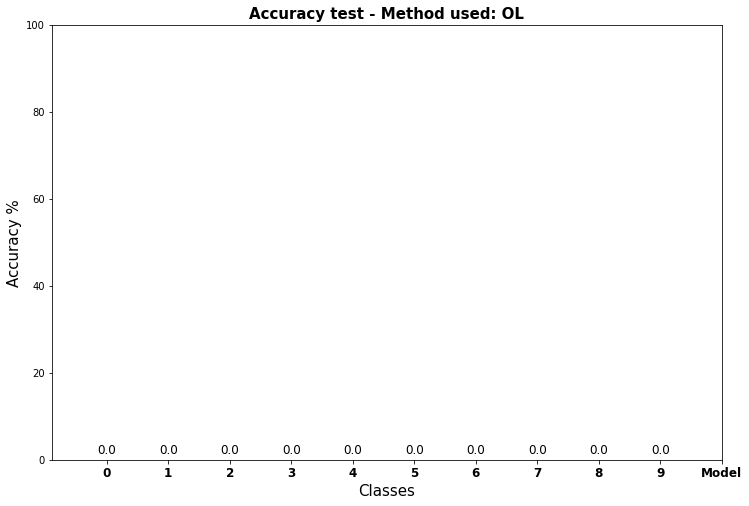

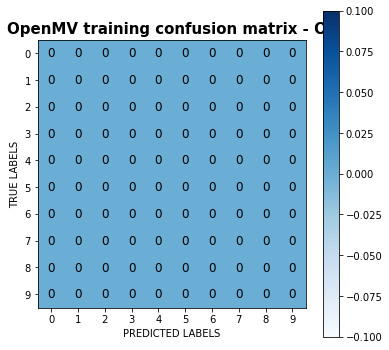

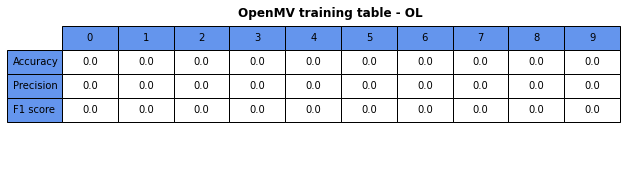

In [36]:
#import importlib
#importlib.reload(Kmeans_lib)

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"  

feat = features_saved[1,:]

##(features_saved.all)
#max(features_saved)

feat.dtype

np.amin(feat)
np.amax(feat)

feat.shape
feat

X = digits_train[1,:]
YY = Model_OL.ML_frozen.predict(X.reshape((1,28,28,1)), verbose = False)

# YY2 = np.array(YY as features_saved)

np.amin(YY)
np.amax(YY)

#from simulation_lib import *


# IDEE METRICHE PER SIMULAZIONE 

#plot_barChart(Model_OL)
#plot_confMatrix(Model_OL)
#plot_table(Model_OL)

from lib import simulation_lib as sim_lib
sim_lib.plot_barChart(Model_OL)
sim_lib.plot_confMatrix(Model_OL)
sim_lib.plot_table(Model_OL)